# Planetary Nebula Production <a class="tocSkip">
    
This notebook is used to test and showcase the results of my first project. I use spectroscopic data from the [Multi Unit Spectroscopic Explorer](https://www.eso.org/sci/facilities/develop/instruments/muse.html) (MUSE) that has been observed as part of the [PHANGS](https://sites.google.com/view/phangs/home) collaboration.
    
I will use a set of line maps of emission lines to identify Planetary Nebula in the data an measure their brightness. This can then be used to fit an empiric relation and hence measure the distance to the galaxy.
    
This notebook is used for developement. Final code is moved to the `pymuse` packge in the `src` folder. Any production scripts reside in the `scripts` folder.

## Preparation
 
### Load Basic Packages
    
First we load a bunch of common packages that are used across the project. More specific packages that are only used in one section are loaded later to make it clear where they belong to (this also applies to all custom moduls that were written for this project).

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

# some basic packages
import os                 # filesystem related stuff
import json
from pathlib import Path  # use instead of os.path and glob
import sys                # mostly replaced by pathlib

import errno      # more detailed error messages
import warnings   # handles warnings
import logging    # use logging instead of print

from collections import OrderedDict  

# packages for scientific computing
import numpy as np
import scipy as sp

# packages for creating plots and figures
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# special functions for astronomy 
from astropy.table import Table  # useful datastructure
from astropy.table import vstack # combine multiple tables

from astropy.io import fits      # open fits files
from astropy.io import ascii     # handle normal files

from astropy.wcs import WCS               # handle coordinates
from astropy.coordinates import SkyCoord  # convert pixel to sky coordinates

from astropy.stats import sigma_clipped_stats  # calcualte statistics of images

import astropy.units as u        # handle units

we use the `logging` module to handle informations and warnings (this does not always work as expected in jupyter notebooks).

In [2]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

### Read in data

this uses the `ReadLineMaps` class from the `pymuse.io` module. To use it, we first need to specify the path to the data folder

In [3]:
from pymuse.io import ReadLineMaps

name = 'NGC5068'

# first we need to specify the path to the raw data
data_raw = Path('d:\downloads\MUSEDAP')
basedir = Path('..')

with open(basedir / 'data' / 'interim' / 'parameters.json') as json_file:
    parameters = json.load(json_file)

# list all files in the specified directory
galaxies = [x.name for x in data_raw.iterdir() if x.is_dir()]
print(', '.join(map(str,galaxies)))

# read in the data we will be working with and print some information
galaxy = ReadLineMaps(data_raw / name)
setattr(galaxy,'mu',parameters[galaxy.name]['mu'])
setattr(galaxy,'alpha',parameters[galaxy.name]['power_index'])
setattr(galaxy,'completeness_limit',parameters[galaxy.name]['completeness_limit'])

#print('\n' + str(NGC628))

IC5332, NGC1087, NGC1365, NGC1512, NGC1566, NGC1672, NGC2835, NGC3351, NGC3627, NGC4254, NGC4535, NGC5068, NGC628, NGC628p
INFO:pymuse.io:loading NGC5068
INFO:pymuse.io:file loaded with 4 extensions


## Source Detection

There are two different approaches to identifying sources in an image. The first utilizes PSF fitting and uses implementations from astropy. The other uses the external `SExtractor` package which detects peaks and classifies them with a neural network.

In [4]:
from photutils import DAOStarFinder            # DAOFIND routine to detect sources
from photutils import IRAFStarFinder           # IRAF starfind routine to detect star

from pymuse.detection import detect_unresolved_sources

In [ ]:
_roundness   = 0.8
_sharpnesslo = 0.1
_sharpnesshi = 0.9

sources = detect_unresolved_sources(galaxy,
                                    'OIII5006',
                                    StarFinder=DAOStarFinder,
                                    threshold=8,
                                    roundlo=-_roundness,
                                    roundhi=_roundness,
                                    sharplo=_sharpnesslo,
                                    sharphi=_sharpnesshi,
                                    save=True)

#### Plot detected sources

In [ ]:
from pymuse.plot.plot import plot_sky_with_detected_stars

In [ ]:
position = np.transpose((sources['x'], sources['y']))

save_file = Path.cwd() / '..' / 'reports' / 'figures' / f'{NGC628.name}_sky_sources_DAO.pdf'
plot_sky_with_detected_stars(data=NGC628.OIII5006_DAP,
                             wcs=NGC628.wcs,
                             positions=position,
                             filename=save_file)

## Completeness limit

In [ ]:
from pymuse.detection import completeness_limit

In [ ]:
mock_sources = completeness_limit(
                   galaxy,
                   'OIII5006',
                   DAOStarFinder,
                   threshold=8,
                   iterations=5,
                   roundlo=-_roundness,
                   roundhi=_roundness,
                   sharplo=_sharpnesslo,
                   sharphi=_sharpnesshi
                                 )

## Flux measurement

In the previous step we detected potential PN candidates by their [OIII] emission. This means we know their position but lack exact flux measurments. In this section we measure the flux of the identified objects in different emission lines that are used in later steps. 

In [5]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)
from astropy.coordinates import SkyCoord

from extinction import ccm89     # calculate extinction Cardelli et al. (1989)

from pymuse.photometry import measure_flux

In [ ]:
alpha = galaxy.alpha

flux = measure_flux(galaxy,sources,alpha,aperture_size=2.,background='local')

for col in ['HA6562','NII6583','SII6716']:
    flux[col][flux[col]<0] = flux[f'{col}_err'][flux[col]<0]
    flux[col][flux[col]/flux[f'{col}_err']<3] = flux[f'{col}_err'][flux[col]/flux[f'{col}_err']<3]
    
# calculate astronomical coordinates for comparison
flux['SkyCoord'] = SkyCoord.from_pixel(flux['x'],flux['y'],galaxy.wcs)

# calculate magnitudes from measured fluxes
flux['mOIII'] = -2.5*np.log10(flux['OIII5006']*1e-20) - 13.74
flux['dmOIII'] = np.abs( 2.5/np.log(10) * flux['OIII5006_err'] / flux['OIII5006'] )

# correct for milky way extinction
extinction = ccm89(wave=np.array([5007.]),a_v=0.2,r_v=3.1,unit='aa')[0]
flux['mOIII'] -= extinction

## Emission line diagnostics

We built a catalgoue of possible planetary nebula and measuerd different emission lines. However this catalogue still contains objects that are similar to PN like HII regions or supernova remenants (SNR). In this next step we use emission line diagnostics to eliminate those contanimations. The distance modulus $\mu$ is defined as the difference between the apparent and the absolute magnitude. By definition of the absolute magnitude, this relates to the distance $d$ in parsec as 
$$
\begin{align}
\mu = m - M \\
d = 10^{1+\frac{\mu}{5}}
\end{align}
$$

 1. filter out HII regions
    $$
     4 > \log_{10} \frac{[\mathrm{OIII}]}{\mathrm{H}\alpha +[\mathrm{NII}]} > -0.37 M_{[\mathrm{OIII}]} - 1.16
    $$
 2. filter out SNR
    $$
     \mathrm{H}\alpha / [\mathrm{SII}] < 2.5
    $$
    
 3. estimate completness limit and remove fainter sources
    

In [ ]:
from pymuse.analyse import emission_line_diagnostics, Distance

print(f'emission line diagnostics for {galaxy.name}')
tbl = emission_line_diagnostics(flux,galaxy.mu,galaxy.completeness_limit)

In [ ]:
filename = basedir / 'reports' / 'catalogues' / f'pn_candidates_{galaxy.name}.txt'
with open(filename,'w',newline='\n') as f:
    tbl['RaDec'] = tbl['SkyCoord'].to_string(style='hmsdms',precision=2)
    for col in tbl.colnames:
        if col not in ['id','RaDec','type']:
            tbl[col].info.format = '%.3f' 
    ascii.write(tbl[['id','type','x','y','RaDec','OIII5006','OIII5006_err','mOIII','dmOIII','HA6562','HA6562_err',
                          'NII6583','NII6583_err','SII6716','SII6716_err']][tbl['type']!='NaN'],
                f,format='fixed_width',delimiter='\t',overwrite=True)

### Compare velocity dispersion of PN to HII-regions and SNR

In [ ]:
completeness = galaxy.completeness_limit
m = np.nanmean(tbl[tbl['mOIII']<completeness]['OIII5006_SIGMA'])
print(f'all: v_sig = {m}')

for t in ['PN','HII','SNR']:
    m = np.nanmean(tbl[(tbl['type']==t) & (tbl['mOIII']<completeness)]['OIII5006_SIGMA'])
    std = np.nanstd(tbl[(tbl['type']==t) & (tbl['mOIII']<completeness)]['OIII5006_SIGMA'])

    print(f'{t}: v_sig = {m:.2f} +- {std:.2f}')

### Visualize the result of the classification

In [ ]:
from pymuse.plot.pnlf import plot_emission_line_ratio
filename = basedir / 'reports' / 'figures' / f'{galaxy.name}_emission_line'
plot_emission_line_ratio(tbl,galaxy.mu,filename=filename)

In [ ]:
from photutils import CircularAperture
from astropy.visualization import simple_norm

# ====== define input parameters =============================
galaxy = NGC628
labels=['SII6716','HA6562','OIII5006']
wcs=NGC628.wcs
# ============================================================

table = tbl

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(20,10),subplot_kw={'projection':wcs})

norm = simple_norm(galaxy.HA6562,'linear',clip=False,max_percent=95)
ax1.imshow(galaxy.HA6562,norm=norm,cmap=plt.cm.Greens_r)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
ax2.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues_r)

for t,c in zip(['HII','SNR','PN'],['black','red','yellow']):
    
    sub = table[table['type']==t]
    positions = np.transpose([sub['x'],sub['y']])
    apertures = CircularAperture(positions, r=6)
    apertures.plot(color=c,lw=.5, alpha=1,ax=ax1)
    apertures.plot(color=c,lw=.5, alpha=1,ax=ax2)

ax1.set_title('HA6562')
ax2.set_title('OIII5006')

plt.savefig(basedir / 'reports' / 'figures' / 'NGC628_detections_classification.pdf')

## Planetary nebula luminosity function

The absolute magnitude of PN is described by (this is an empirical relation)
$$ 
\begin{align}
N(M) &\propto e^{0.307 M} \left( 1- e^{3(M^*-M)} \right) \\
&\propto e^{0.307 (m-\mu)} \left( 1- e^{3(M^*-m+\mu)} \right) \\
&\propto e^{0.307 (m-\mu)} - e^{3M^*-2.693(m-\mu)} 
\end{align}
$$
To use this function in our Maximum Likelihood we need to normalize it. The indefinite integral is
$$
\begin{align}
\int N(m)\; \mathrm{d} m \propto \frac{e^{0.307(m-\mu)}}{0.307} + \frac{e^{3M^* - 2.693(m-\mu)}}{2.693}
\end{align}
$$
The luminosity function has a root when $M^* - m + \mu =0$. We use this for the lower bound normalization. For the upper bound we use the luminosity for which we are confindent to detect all sources (=completeness limit).

We can already use the normalized luminosity function for the maximum likelihood fitting. However we cannot really illustrate the result. To do this we need to introduce some binning. Then we can show the fit similar to a curve fit. Because we sum the PN in the bins, we don't plot the luminosity function but the integrated function. 

### With maximum likelihood

**Note**: the function which is used for the likelihood must be normalized


In [9]:
name = 'NGC628'
filename = basedir / 'reports' / 'catalogues' / f'pn_candidates_{name}.txt'
tbl = ascii.read(str(filename),format='fixed_width',delimiter='\t')

In [10]:
from pymuse.analyse import MaximumLikelihood, PNLF, pnlf

completeness = 28.8

data = tbl[(tbl['type']=='PN') & (tbl['mOIII']<completeness)]['mOIII']
err  = tbl[(tbl['type']=='PN') & (tbl['mOIII']<completeness)]['dmOIII']
#data = data[data>26]

fitter = MaximumLikelihood(pnlf,
                           data,
                           mhigh=completeness)

# a good guess would be mu_guess = min(data)-Mmax
print(galaxy.name)
mu = fitter([24])[0]

NGC5068
INFO:pymuse.analyse:searching for best parameters with 142 data points
mu = 30.065 + 0.067 - 0.067 


| Name | measured | error | literature | 
|------|----------|-------|------------|
IC5332 | 30.228 | 0.044 | 30.39 |
NGC1087 |31.019 | 0.321 | 31.99 |
NGC1365 |31.108 | 0.219 | 31.18 |
NGC1512 |31.103 | 0.063 | 30.32 |
NGC1566 |no PSF data | | |
NGC1672 |31.194 | 0.051 | 30.08|
NGC2835 |29.816 | 0.171 | 30.085|
NGC3351 |29.942 | 0.130 | 30.0|
NGC3627 |30.292 | 0.055 | 29.91|
NGC4254 |31.429 | 0.078 | 30.71|
NGC4535 |31.097 | 0.143 | 31.1|
NGC5068 |29.312 | 0.208 | 29.16|
NGC628  |30.077 | 0.073 | 29.91|

### Plot the fit

to plot the fit we need to bin the data

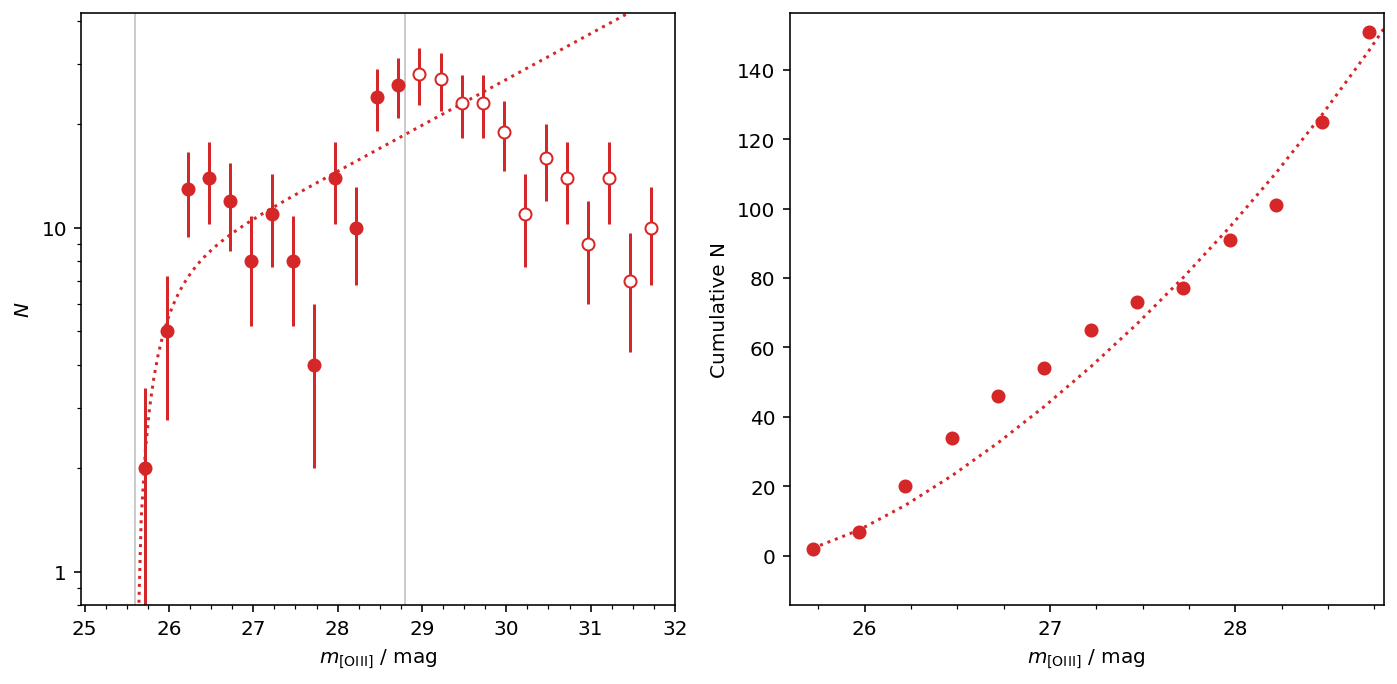

In [14]:
from pymuse.plot.pnlf import plot_pnlf
filename = basedir / 'reports' / 'figures' / f'{galaxy.name}_PNLF'
plot_pnlf(tbl[tbl['type']=='PN']['mOIII'],mu,completeness,binsize=0.25,mhigh=32,filename=filename)

INFO:pymuse.analyse:searching for best parameters with 222 data points
mu = 30.691 + 0.063 - 0.063 
INFO:pymuse.analyse:searching for best parameters with 58 data points
mu = 31.047 + 0.408 - 0.408 
INFO:pymuse.analyse:searching for best parameters with 113 data points
mu = 31.108 + 0.224 - 0.224 
INFO:pymuse.analyse:searching for best parameters with 392 data points
mu = 31.103 + 0.057 - 0.057 
INFO:pymuse.analyse:searching for best parameters with 100 data points
mu = 31.194 + 0.046 - 0.046 
INFO:pymuse.analyse:searching for best parameters with 112 data points
mu = 30.337 + 0.056 - 0.056 
INFO:pymuse.analyse:searching for best parameters with 430 data points
mu = 30.495 + 0.029 - 0.029 
INFO:pymuse.analyse:searching for best parameters with 111 data points
mu = 30.394 + 0.081 - 0.081 
INFO:pymuse.analyse:searching for best parameters with 211 data points
mu = 31.428 + 0.092 - 0.092 
INFO:pymuse.analyse:searching for best parameters with 269 data points
mu = 31.097 + 0.142 - 0.142 
I

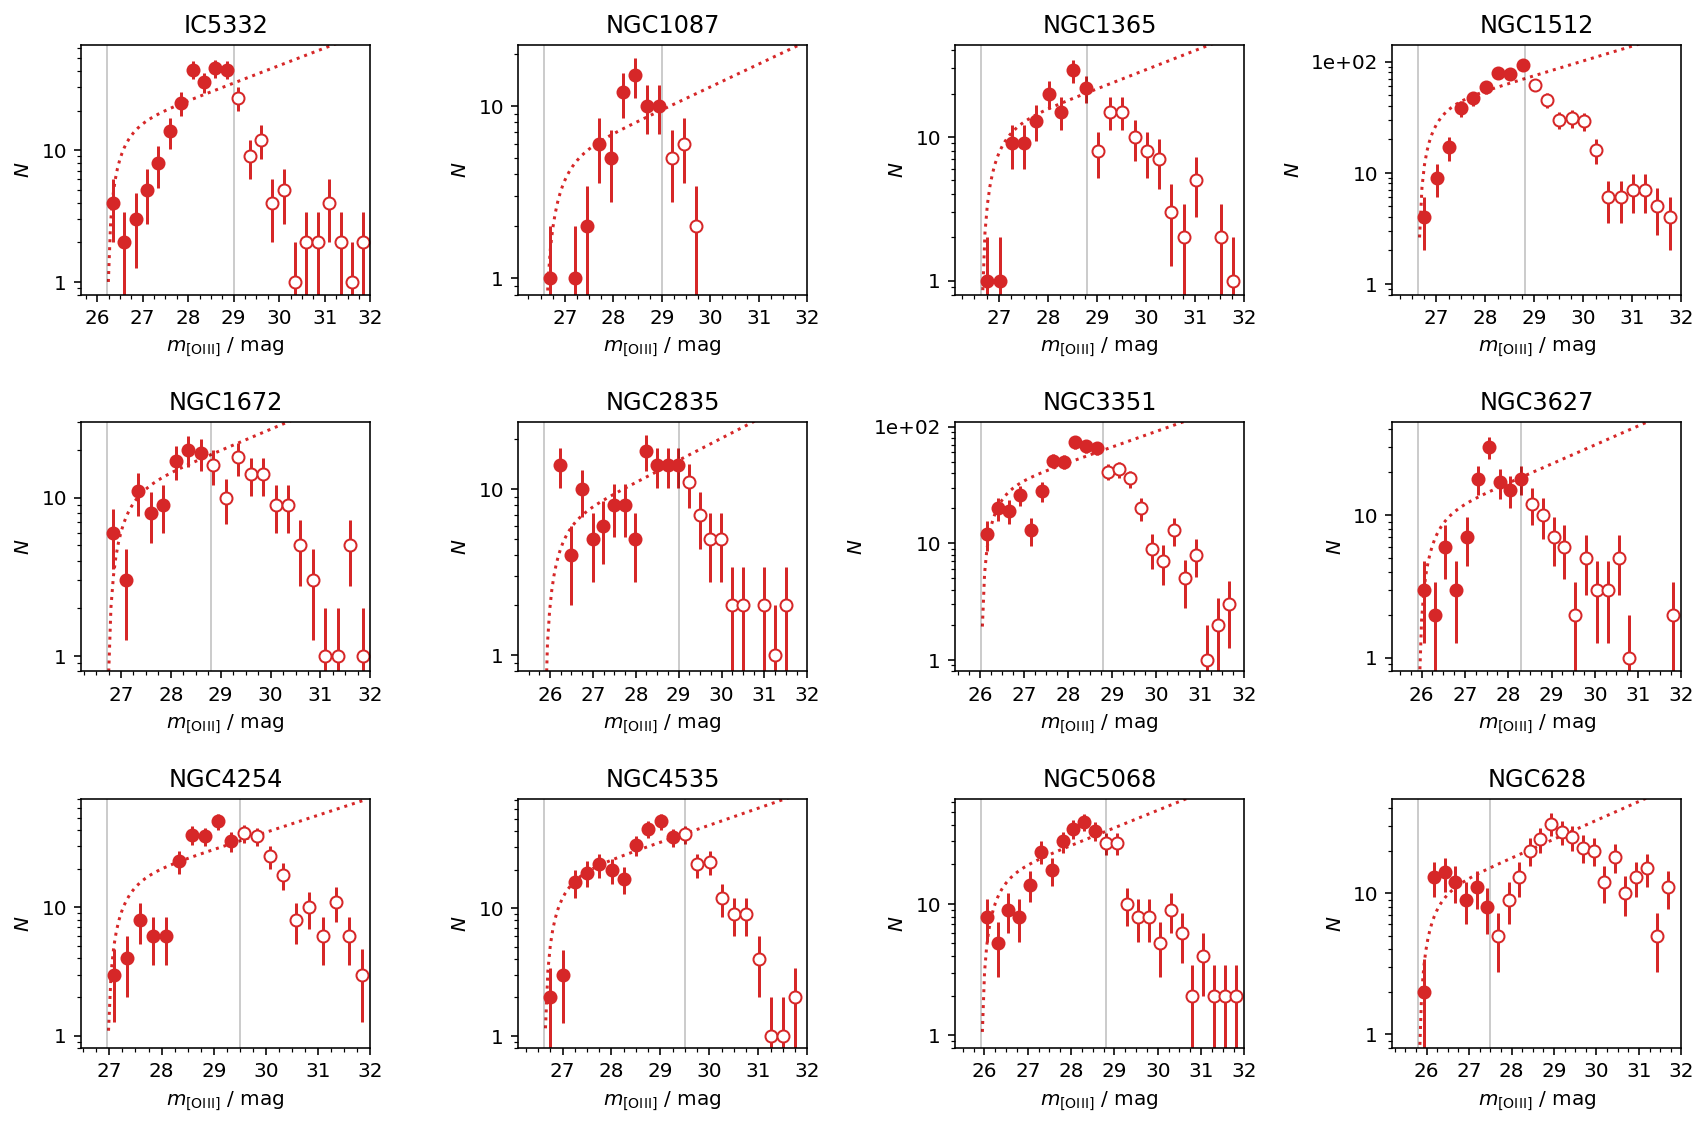

In [8]:
from pymuse.analyse import MaximumLikelihood, PNLF, pnlf

binsize=0.25
Mmax = -4.47
names = ['IC5332', 'NGC1087', 'NGC1365', 'NGC1512', 'NGC1672', 'NGC2835', 'NGC3351', 'NGC3627', 'NGC4254', 'NGC4535', 'NGC5068', 'NGC628']
color = 'tab:red'

fig, axes = plt.subplots(nrows=3,ncols=4,figsize=(12,8))

for i, ax in enumerate(fig.axes):
    
    name = names[i]
    
    completeness = parameters[name]['completeness_limit']
    
    filename = basedir / 'reports' / 'catalogues' / f'pn_candidates_{name}.txt'
    tbl = ascii.read(str(filename),format='fixed_width',delimiter='\t')
    data = tbl[(tbl['type']=='PN')]['mOIII']
    err  = tbl[(tbl['type']=='PN')]['dmOIII']
    data = data[data>26]

    fitter = MaximumLikelihood(pnlf,
                               data[data<completeness],
                               mhigh=completeness)

    # a good guess would be mu_guess = min(data)-Mmax
    mu = fitter([24])[0]
   
    mlow = Mmax+mu
    mhigh = 32

    N = len(data[data<completeness])
    
    hist, bins  = np.histogram(data,np.arange(mlow,mhigh,binsize),normed=False)
    err = np.sqrt(hist)
    # midpoint of the bins is used as position for the plots
    m = (bins[1:]+bins[:-1]) / 2
    
    # for the fit line we use a smaller binsize
    binsize_fine = 0.05
    bins_fine = np.arange(mlow,mhigh,binsize_fine)
    m_fine = (bins_fine[1:]+bins_fine[:-1]) /2

    # scatter plot
    ax.errorbar(m[m<completeness],hist[m<completeness],yerr=err[m<completeness],
                 marker='o',ms=6,mec=color,mfc=color,ls='none',ecolor=color)
    ax.errorbar(m[m>=completeness],hist[m>=completeness],yerr=err[m>completeness],
                 marker='o',ms=6,mec=color,mfc='white',ls='none',ecolor=color)
    ax.plot(m_fine,binsize/binsize_fine*N*PNLF(bins_fine,mu=mu,mhigh=completeness),c=color,ls='dotted')
    ax.axvline(completeness,c='black',lw=0.2)
    ax.axvline(mu+Mmax,c='black',lw=0.2)

    # adjust plot
    ax.set_yscale('log')
    ax.set_xlim([1.1*mlow-0.1*mhigh,mhigh])
    ax.set_ylim([0.8,1.5*np.max(hist)])
    ax.set_xlabel(r'$m_{[\mathrm{OIII}]}$ / mag')
    ax.set_ylabel(r'$N$')
    
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    ax.set_title(name)
    
plt.tight_layout()
filename = basedir / 'reports' / 'figures' / f'all_objects_PNLF'
plt.savefig(filename.with_suffix('.pdf'),bbox_inches='tight')
plt.show()

### Distance in parsec

the measured distances are in the form of the distance modulus $\mu = m-M$ which is the difference between apparent and absolute magnitude. By defintion of the absolte magnitude, we can convert this number into a distance in pc
$$
d = 10^{\frac{\mu}{5}+1} = 10 \cdot \exp\left( \ln 10 \frac{\mu}{5} \right) \\
\delta d = \frac{\ln 10}{5} 10 \exp\left( \ln 10 \frac{\mu}{5} \right) \delta \mu = 0.2 \ln 10 \; d \; \delta \mu
$$

In [ ]:
def distance_modulus_to_parsec(mu,mu_err=np.array([])):
    
    d = 10 * np.exp(np.log(10)*mu/5)
    if len(mu_err) > 0:
        d_err = 0.2 * np.log(10) * d * mu_err
    print(f'd = ({d/1e6:.2f} + {d_err[0]/1e6:.2f} - {d_err[1]/1e6:.2f}) Mpc')
    
    return d, d_err

d,d_err = distance_modulus_to_parsec(30.033,np.array([0.014,0.015]))